# Import and global variables

In [1]:
import matplotlib.pyplot as plt

input_pts_label = "sigma_t"
output_pts_label = "e_s"
delta_epsilon=0.0005

# Problem definition

In [2]:
import random

class Oedometer:
    def __init__(self, e_0: float = 1.00, C_c: float = 0.005, delta_epsilon: float = 0.0005,
                 sigma_t: float = 1.00, max_n: int = 50, rand_epsilon:bool=False, **kwargs):
        self.max_n = max_n

        # Standardwerte als Listen setzen
        self.e_0 = [e_0]
        self.C_c = [C_c]
        self.sigma_t = [sigma_t]
        self.delta_epsilon = []
        self.total_epsilon = [0]

        # Initiale Listen für Berechnungen
        self.sigma_t = [sigma_t]
        self.delta_sigma = []
        self.e_s = []
        self.delta_epsilon = [delta_epsilon]

        # Dynamische Zuweisung von kwargs, falls vorhanden
        for key, value in kwargs.items():
            if hasattr(self, key):  # Nur vorhandene Attribute setzen
                setattr(self, key, [value])

        # Berechnungen durchführen
        self.__calc_sigma_t_p1()

        # Listenlängen anpassen
        self.__adjust_list_lengths()
        self.__calc_total_epsilon()

    def __adjust_list_lengths(self):
        """ Passt ALLE Listen-Attribute an `max_n` an. """
        attributes = ['e_0', 'C_c', 'delta_epsilon', 'sigma_t', 'sigma_t', 'delta_sigma', 'e_s']
        for attr in attributes:
            value_list = getattr(self, attr, [])
            current_length = len(value_list)

            if current_length > self.max_n:
                setattr(self, attr, value_list[:self.max_n])  # Kürzen
            elif current_length < self.max_n:
                setattr(self, attr, value_list + [value_list[-1] if value_list else 0] * (self.max_n - current_length))  # Auffüllen

    def __calc_total_epsilon(self):
        for i in range(len(self.delta_epsilon)-1):
            self.total_epsilon.append(self.total_epsilon[i] + self.delta_epsilon[i])

    def __calc_e_s(self, sigma_t):
        """ Berechnet `e_s` aus `sigma_t`. """
        e_s = (1 + self.e_0[0]) / self.C_c[0] * sigma_t
        self.e_s.append(e_s)
        return e_s

    def __calc_sigma_t_p1(self):
        """ Berechnet `sigma_t` und `delta_sigma` für die nächsten Schritte. """
        for i in range(self.max_n):  # -1, weil sigma_t bereits gesetzt ist
            e_s = self.__calc_e_s(self.sigma_t[i])
            delta_sigma = e_s * self.delta_epsilon[0]
            sigma = self.sigma_t[i] + delta_sigma
            self.sigma_t.append(sigma)
            self.delta_sigma.append(delta_sigma)

# Generate random trainingsdata

In [3]:
from random import randint

oedo_para = {
    'max_n': 100,
    'e_0': 1.0,
    'C_c': 0.005,
    'delta_epsilon' : delta_epsilon,
}
list_output = []
list_input = []
n = oedo_para['max_n']
oedo_para['max_n'] = 1
for i in range(n):
    oedo_para['sigma_t'] = randint(1,50)
    oedo_output = Oedometer(**oedo_para)
    list_output.append(oedo_output.e_s[0])
    list_input.append(oedo_output.sigma_t[0])

# Show trainingsdata

In [4]:
import pandas as pd
from pandas import DataFrame

pd.DataFrame([list_input, list_output])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,9.0,17.0,45.0,25.0,24.0,29.0,35.0,15.0,40.0,46.0,...,2.0,15.0,35.0,17.0,44.0,2.0,46.0,42.0,37.0,14.0
1,3600.0,6800.0,18000.0,10000.0,9600.0,11600.0,14000.0,6000.0,16000.0,18400.0,...,800.0,6000.0,14000.0,6800.0,17600.0,800.0,18400.0,16800.0,14800.0,5600.0


# Convert list to tensor

In [5]:
from torch import tensor
import torch

sigma_t_tensor = torch.tensor(list_input, dtype=torch.float).unsqueeze(-1)
e_s_tensor = torch.tensor(list_output, dtype=torch.float).unsqueeze(-1)

# Einfaches Feedforward-Netz

# Define SimpleRegressor Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

model = SimpleRegressor()

# Training

In [7]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5000
loss_history = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(sigma_t_tensor)
    loss = loss_fn(pred, e_s_tensor)
    loss.backward()
    loss_history.append(loss.item())
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 138716960.000000
Epoch 100: Loss = 18432360.000000
Epoch 200: Loss = 32317.492188
Epoch 300: Loss = 29755.869141
Epoch 400: Loss = 27378.242188
Epoch 500: Loss = 24849.810547
Epoch 600: Loss = 22261.812500
Epoch 700: Loss = 19689.150391
Epoch 800: Loss = 17192.818359
Epoch 900: Loss = 14821.009766
Epoch 1000: Loss = 12610.442383
Epoch 1100: Loss = 10587.031250
Epoch 1200: Loss = 8766.829102
Epoch 1300: Loss = 7157.091309
Epoch 1400: Loss = 5757.470703
Epoch 1500: Loss = 4561.178223
Epoch 1600: Loss = 3556.290283
Epoch 1700: Loss = 2727.079346
Epoch 1800: Loss = 2055.189453
Epoch 1900: Loss = 1520.990601
Epoch 2000: Loss = 1104.481445
Epoch 2100: Loss = 786.257324
Epoch 2200: Loss = 548.231384
Epoch 2300: Loss = 374.015259
Epoch 2400: Loss = 249.440506
Epoch 2500: Loss = 162.421387
Epoch 2600: Loss = 103.151779
Epoch 2700: Loss = 63.819149
Epoch 2800: Loss = 38.414352
Epoch 2900: Loss = 22.462780
Epoch 3000: Loss = 12.745688
Epoch 3100: Loss = 7.005270
Epoch 3200: Loss =

# Loss function

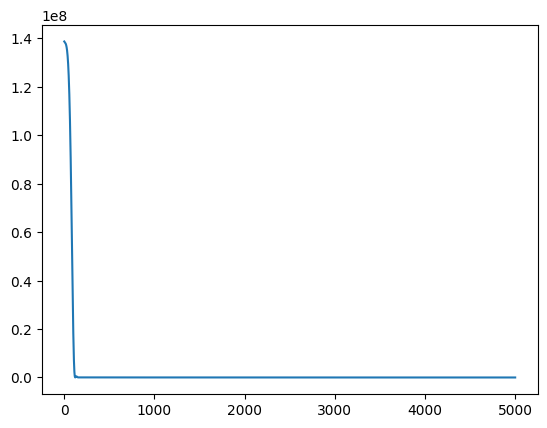

In [8]:
plt.plot(loss_history, label="Loss")
plt.show()

In [9]:
pred_input = torch.tensor([1.0], dtype=torch.float).unsqueeze(-1) 

model.eval()
with torch.no_grad():
    pred = model(pred_input)

print(pred)

tensor([[400.0014]])


# Plot of stress–strain curve

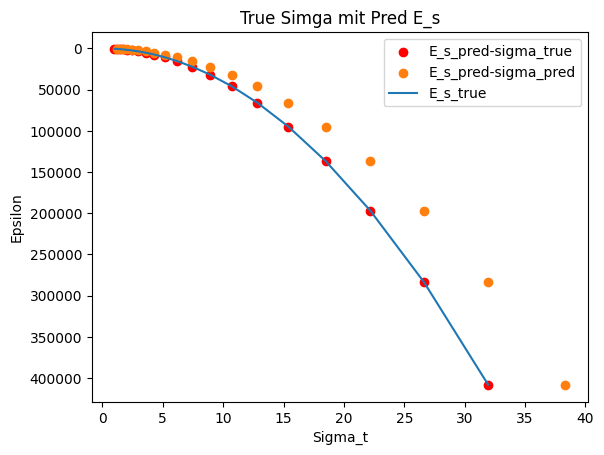

In [10]:
def plot_result(iterations=20, start_sigma=1, delta_epsilon=0.0005):
    oedo_para = {
    'max_n': iterations,
    'e_0': 1.0,
    'C_c': 0.005,
    'delta_epsilon' : delta_epsilon,
    'sigma_t' : start_sigma,
    }

    oedo = Oedometer(**oedo_para)
    sigma_true = oedo.sigma_t
    e_s_true = oedo.e_s
    
    # print(sigma_true)
    # print(e_s_true)
    model.eval()
    e_s_pred = []
    e_s_true_plot = []
    sigma_t = start_sigma
    sigma_pred = []
    with torch.no_grad():
        for i in range(iterations):
            sigma_true_tensor = torch.tensor(sigma_true[i], dtype=torch.float).unsqueeze(-1) 
            pred = model(sigma_true_tensor)
            e_s_pred.append(pred * sigma_true[i])
            e_s_true_plot.append(e_s_true[i] * sigma_true[i])

            sigma_t = sigma_t + pred * delta_epsilon
            sigma_pred.append(sigma_t)
    # Plot der Losskurve
    plt.scatter(sigma_true, e_s_pred, label='E_s_pred-sigma_true').set_color("red")
    plt.scatter(sigma_pred, e_s_pred, label='E_s_pred-sigma_pred')
    plt.plot(sigma_true, e_s_true_plot, label='E_s_true')

    plt.gca().invert_yaxis()
    plt.xlabel('Sigma_t')
    plt.ylabel('Epsilon')
    plt.title('True Simga mit Pred E_s')
    plt.legend()
    plt.show()
    
plot_result()